
# Transforms v2: End-to-end object detection/segmentation example

<div class="alert alert-info"><h4>Note</h4><p>Try on [Colab](https://colab.research.google.com/github/pytorch/vision/blob/gh-pages/main/_generated_ipynb_notebooks/plot_transforms_e2e.ipynb)
    or `go to the end <sphx_glr_download_auto_examples_transforms_plot_transforms_e2e.py>` to download the full example code.</p></div>

Object detection and segmentation tasks are natively supported:
``torchvision.transforms.v2`` enables jointly transforming images, videos,
bounding boxes, and masks.

This example showcases an end-to-end instance segmentation training case using
Torchvision utils from ``torchvision.datasets``, ``torchvision.models`` and
``torchvision.transforms.v2``. Everything covered here can be applied similarly
to object detection or semantic segmentation tasks.


In [3]:
import os

# Remove the existing 'vision' directory if it exists, to ensure a clean clone
!rm -rf vision

# Clone the entire pytorch/vision repository
!git clone https://github.com/pytorch/vision.git

# Copy helpers.py to the current directory so it can be imported
#!cp vision/gallery/transforms/helpers.py .

Cloning into 'vision'...
remote: Enumerating objects: 704866, done.
remote: Counting objects: 100% (368/368), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 704866 (delta 289), reused 108 (delta 105), pack-reused 704498 (from 5)
Receiving objects: 100% (704866/704866), 1.24 GiB | 45.56 MiB/s, done.
Resolving deltas: 100% (660067/660067), done.


In [4]:
!cp vision/gallery/transforms/helpers.py .

In [5]:
import pathlib

import torch
import torch.utils.data

from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2

torch.manual_seed(0)

# This loads fake data for illustration purposes of this example. In practice, you'll have
# to replace this with the proper data.
# If you're trying to run that on Colab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
# After cloning the repo, the path to assets will be inside the 'vision' directory
ROOT = pathlib.Path("vision/gallery/assets") / "coco"
IMAGES_PATH = str(ROOT / "images")
ANNOTATIONS_PATH = str(ROOT / "instances.json")
from  helpers import plot

## Dataset preparation

We start off by loading the :class:`~torchvision.datasets.CocoDetection` dataset to have a look at what it currently
returns.



In [6]:
dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH)

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{type(target[0]) = }\n{target[0].keys() = }")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'list'>
type(target[0]) = <class 'dict'>
target[0].keys() = dict_keys(['segmentation', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])


Torchvision datasets preserve the data structure and types as it was intended
by the datasets authors. So by default, the output structure may not always be
compatible with the models or the transforms.

To overcome that, we can use the
:func:`~torchvision.datasets.wrap_dataset_for_transforms_v2` function. For
:class:`~torchvision.datasets.CocoDetection`, this changes the target
structure to a single dictionary of lists:



In [7]:
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=("boxes", "labels", "masks"))

sample = dataset[0]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }\n{type(target['masks']) = }")

type(img) = <class 'PIL.Image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'masks', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>
type(target['masks']) = <class 'torchvision.tv_tensors._mask.Mask'>


We used the ``target_keys`` parameter to specify the kind of output we're
interested in. Our dataset now returns a target which is dict where the values
are `TVTensors <what_are_tv_tensors>` (all are :class:`torch.Tensor`
subclasses). We're dropped all unncessary keys from the previous output, but
if you need any of the original keys e.g. "image_id", you can still ask for
it.

<div class="alert alert-info"><h4>Note</h4><p>If you just want to do detection, you don't need and shouldn't pass
    "masks" in ``target_keys``: if masks are present in the sample, they will
    be transformed, slowing down your transformations unnecessarily.</p></div>

As baseline, let's have a look at a sample without transformations:



In [8]:
# load a single image
img1 = v2.ToImage()(dataset[0][0]).unsqueeze(0)
img1c = torch.clone(img1)
img2 = v2.ToImage()(dataset[1][0]).unsqueeze(0)
print(img1.shape)
print(img1c.shape)
print(img2.shape)

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 500, 500])


In [73]:
import torch.nn.functional as F
# conv for cross
corr_map = F.conv2d(img1, img1c)
# corr_map = F.conv2d(img2, img2)
print(corr_map)
# ncc = NCC(img1[0].to(float))

tensor([[[[157]]]], dtype=torch.uint8)


In [9]:
# Nomalied cross correlation as a loss
def ncc(img1, img2):
    img1 = img1.to(float)
    img2 = img2.to(float)
    img1_mean = img1.mean()
    img2_mean = img2.mean()
    img1_std = img1.std()
    img2_std = img2.std()
    corr = ((img1 - img1_mean) * (img2 - img2_mean)).mean()
    corr = corr / (img1_std * img2_std)
    return corr

In [13]:
ncc(img2, img2)

False

In [18]:
# soft histogram
import torch
import torch.nn as nn

class SoftHistogram(nn.Module):
    def __init__(self, bins=32, min=0, max=1, sigma=0.01):
        super(SoftHistogram, self).__init__()
        self.bins = bins
        self.min = min
        self.max = max
        self.sigma = sigma
        # Definiamo i centri dei bin come parametri fissi (senza gradienti) [4, 5]
        self.centers = nn.Parameter(torch.linspace(min, max, bins), requires_grad=False)

    def forward(self, x):
        # x deve essere normalizzato tra 0 e 1. Lo appiattiamo per il calcolo [6]
        x = x.reshape(-1, 1)

        # Calcoliamo la distanza tra ogni pixel e ogni centro del bin
        # Questo permette a autograd di tracciare le operazioni [7, 8]
        dists = torch.abs(x - self.centers)

        # Utilizziamo un kernel Gaussiano per distribuire "dolcemente" il peso sui bin vicini
        weights = torch.exp(-0.5 * (dists / self.sigma).pow(2))

        # Sommiamo i pesi e normalizziamo per ottenere una distribuzione di probabilità
        hist = weights.sum(dim=0)
        return hist / (hist.sum() + 1e-10)

def compute_entropy(prob):
    # Calcolo dell'entropia di Shannon: H(X) = -sum(p * log(p)) [9, 10]
    return -torch.sum(prob * torch.log(prob + 1e-10))

In [19]:

class SoftJointHistogram2D(nn.Module):
    def __init__(self, bins=32, min_val=0., max_val=1., sigma=0.01):
        super(SoftJointHistogram2D, self).__init__()
        self.bins = bins
        self.sigma = sigma
        # Centri dei bin distribuiti linearmente
        self.centers = nn.Parameter(torch.linspace(min_val, max_val, bins), requires_grad=False)

    def forward(self, img1, img2):
        # Appiattimento delle immagini in vettori (N pixel)
        x = img1.reshape(-1, 1)
        y = img2.reshape(-1, 1)

        # Calcolo dei pesi soft per img1 (Matrice N x Bins)
        dists_x = torch.abs(x - self.centers)
        weights_x = torch.exp(-0.5 * (dists_x / self.sigma).pow(2))
        weights_x = weights_x / (weights_x.sum(dim=1, keepdim=True) + 1e-10)

        # Calcolo dei pesi soft per img2 (Matrice N x Bins)
        dists_y = torch.abs(y - self.centers)
        weights_y = torch.exp(-0.5 * (dists_y / self.sigma).pow(2))
        weights_y = weights_y / (weights_y.sum(dim=1, keepdim=True) + 1e-10)

        # Calcolo dell'istogramma congiunto tramite prodotto di matrici (Bins x Bins)
        # Utilizziamo torch.matmul tra la trasposta di weights_x e weights_y
        joint_hist = torch.matmul(weights_x.t(), weights_y)

        # Normalizzazione per ottenere la probabilità congiunta P(X, Y)
        joint_prob = joint_hist / (joint_hist.sum() + 1e-10)
        return joint_prob

In [20]:
class NMILoss(nn.Module):
    def __init__(self, bins=32):
        super(NMILoss, self).__init__()
        self.bins = bins
        self.soft_hist = SoftHistogram(bins=bins)
        self.joint_hist = SoftJointHistogram2D(bins=bins)

    def compute_entropy(self, p):
        # Calcolo dell'entropia di Shannon: H(A) = -sum(P(a) * log(P(a)))
        # [Fonte 35]
        return -torch.sum(p * torch.log(p + 1e-10))

    def forward(self, target, moving):
        # 1. Calcolo delle probabilità marginali P(T) e P(S) e congiunta P(T, S)
        # In pratica si usano istogrammi soft differenziabili [Fonte 36]
        p_target = self.soft_hist(target)
        p_moving = self.soft_hist(moving)
        p_joint = self.joint_hist(target, moving)

        # 2. Calcolo delle entropie marginali H(T), H(S) e congiunta H(T, S)
        # [Fonte 35, 36]
        h_target = self.compute_entropy(p_target)
        h_moving = self.compute_entropy(p_moving)
        h_joint = self.compute_entropy(p_joint)

        # 3. Calcolo della NMI: (H(T) + H(S)) / H(T, S)
        # [Fonte 37]
        nmi = (h_target + h_moving) / h_joint

        # 4. Restituiamo la NMI negata per la minimizzazione
        # [Fonte 37]
        return -nmi

    def _get_prob(self, img):
        # Funzione di supporto per estrarre la distribuzione di probabilità
        pass # Implementazione specifica dell'istogramma differenziabile

    def _get_joint_prob(self, img1, img2):
        # Funzione di supporto per l'istogramma congiunto
        pass

In [53]:
# NMI loss test [-2,-1]
nmiloss = NMILoss()
print(img1.shape)
print(nmiloss(img1, img1))
print(nmiloss(img2, img2))
print(nmiloss(img1, v2.CenterCrop(img1.shape[2:])(img2)))
print(nmiloss(img2, v2.CenterCrop(img2.shape[2:])(img1)))
print(nmiloss(v2.Grayscale()(img1), dataset[0][1]["masks"]))
print(nmiloss(v2.Grayscale()(img2), dataset[1][1]["masks"]))
print(nmiloss(img1.to(torch.double), torch.rand_like(v2.ToTensor()(img1).to(torch.double))))

torch.Size([1, 3, 512, 512])
tensor(-1.8185)
tensor(-1.9104)
tensor(-1.5735)
tensor(inf)
tensor(-1.0994)
tensor(-1.8708)
tensor(-1.0000, dtype=torch.float64)


In [54]:
# NCC loss test [-2,-1]
print(img1.shape)
print(ncc(img1, img1))
print(ncc(img2, img2))
print(ncc(img1, v2.CenterCrop(img1.shape[2:])(img2)))
print(ncc(img2, v2.CenterCrop(img2.shape[2:])(img1)))
print(ncc(v2.Grayscale()(img1), dataset[0][1]["masks"]))
print(ncc(v2.Grayscale()(img2), dataset[1][1]["masks"]))
print(ncc(img1.to(torch.double), torch.rand_like(v2.ToTensor()(img1).to(torch.double))))

torch.Size([1, 3, 512, 512])
tensor(1.0000, dtype=torch.float64)
tensor(1.0000, dtype=torch.float64)
tensor(-0.0488, dtype=torch.float64)
tensor(-0.0704, dtype=torch.float64)
tensor(-0.1320, dtype=torch.float64)
tensor(-0.1919, dtype=torch.float64)
tensor(0.0006, dtype=torch.float64)


/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


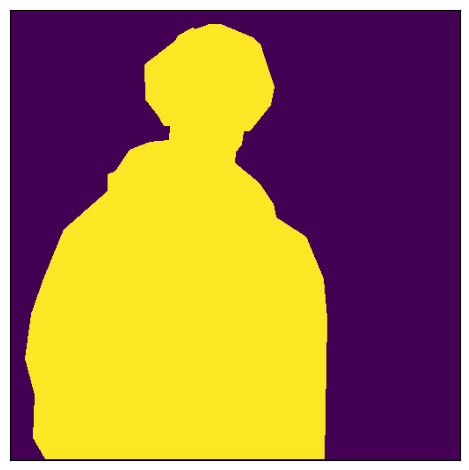

In [41]:
plot(dataset[0][1]["masks"])

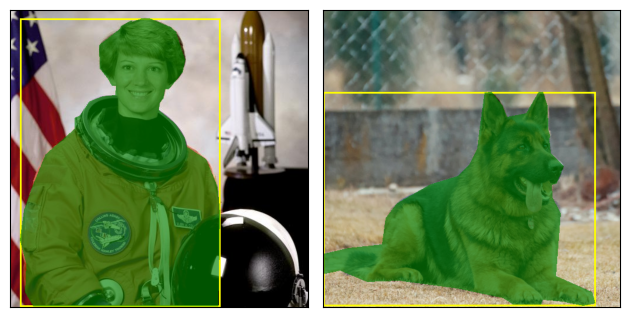

In [32]:
plot([dataset[0], dataset[1]])

## Transforms

Let's now define our pre-processing transforms. All the transforms know how
to handle images, bounding boxes and masks when relevant.

Transforms are typically passed as the ``transforms`` parameter of the
dataset so that they can leverage multi-processing from the
:class:`torch.utils.data.DataLoader`.



In [ ]:
transforms = v2.Compose(
    [
       v2.ToImage() ,
        v2.RandomPhotometricDistort(p=1),
        v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        v2.RandomIoUCrop(),
        v2.RandomHorizontalFlip(p=1),
        v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

dataset = datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH, transforms=transforms)
dataset = datasets.wrap_dataset_for_transforms_v2(dataset, target_keys=["boxes", "labels", "masks"])

A few things are worth noting here:

- We're converting the PIL image into a
  :class:`~torchvision.transforms.v2.Image` object. This isn't strictly
  necessary, but relying on Tensors (here: a Tensor subclass) will
  `generally be faster <transforms_perf>`.
- We are calling :class:`~torchvision.transforms.v2.SanitizeBoundingBoxes` to
  make sure we remove degenerate bounding boxes, as well as their
  corresponding labels and masks.
  :class:`~torchvision.transforms.v2.SanitizeBoundingBoxes` should be placed
  at least once at the end of a detection pipeline; it is particularly
  critical if :class:`~torchvision.transforms.v2.RandomIoUCrop` was used.

Let's look how the sample looks like with our augmentation pipeline in place:



In [ ]:
plot([dataset[0], dataset[1]])

We can see that the color of the images were distorted, zoomed in or out, and flipped.
The bounding boxes and the masks were transformed accordingly. And without any further ado, we can start training.

## Data loading and training loop

Below we're using Mask-RCNN which is an instance segmentation model, but
everything we've covered in this tutorial also applies to object detection and
semantic segmentation tasks.



In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    # We need a custom collation function here, since the object detection
    # models expect a sequence of images and target dictionaries. The default
    # collation function tries to torch.stack() the individual elements,
    # which fails in general for object detection, because the number of bounding
    # boxes varies between the images of the same batch.
    collate_fn=lambda batch: tuple(zip(*batch)),
)

model = models.get_model("maskrcnn_resnet50_fpn_v2", weights=None, weights_backbone=None).train()

for imgs, targets in data_loader:
    loss_dict = model(imgs, targets)
    # Put your training logic here

    print(f"{[img.shape for img in imgs] = }")
    print(f"{[type(target) for target in targets] = }")
    for name, loss_val in loss_dict.items():
        print(f"{name:<20}{loss_val:.3f}")

## Training References

From there, you can check out the [torchvision references](https://github.com/pytorch/vision/tree/main/references) where you'll find
the actual training scripts we use to train our models.

**Disclaimer** The code in our references is more complex than what you'll
need for your own use-cases: this is because we're supporting different
backends (PIL, tensors, TVTensors) and different transforms namespaces (v1 and
v2). So don't be afraid to simplify and only keep what you need.

